# Import Libraries

In [1]:
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
from pathlib import Path
from OAS2_data import OAS2Data

# Load Data

In [ ]:
dataset_size = 1
train_data = OAS2Data(size=dataset_size, data_type='train') # data_type = 'train', 'test', 'eval'
img, lab = train_data[26]

Loaded Labels and Images for train


In [ ]:
test_data = OAS2Data(size=dataset_size, data_type='test')
img, lab = test_data[26]

Loaded Labels and Images for test


In [4]:
len(train_data.data), len(test_data.data)

(8892, 1900)

In [5]:
len(train_data.labels), len(test_data.labels)

(8892, 1900)

In [6]:
class_names = train_data.classes
class_names

['Nondemented', 'Demented']

In [7]:
number_of_labels = test_data.labels
count = 0
for i in range(len(test_data.labels)):
    if number_of_labels[i] == 1:
        count += 1
count

950

# Visualize what we're working with

Text(0.5, 1.0, 'Demented')

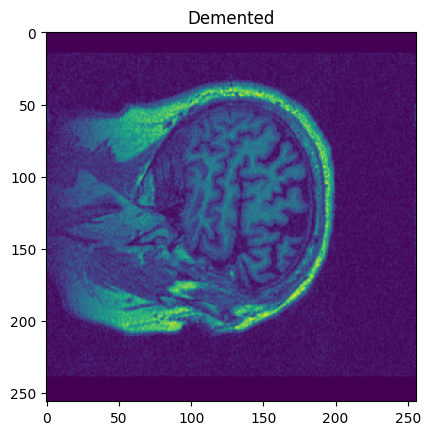

In [8]:
mri, label = test_data[0]
plt.imshow(mri.squeeze())
plt.title(train_data.classes[label])

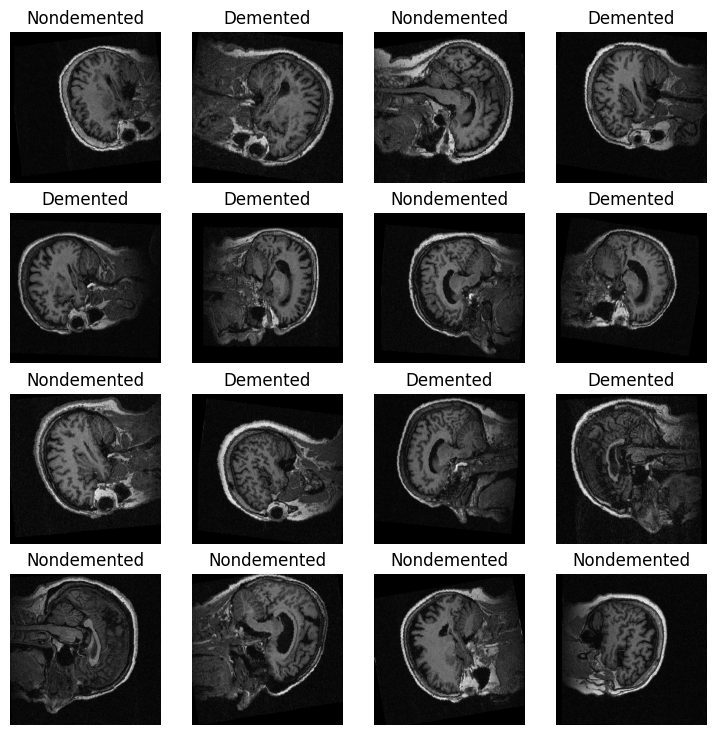

In [9]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# Preparing the DataLoaders and CUDA

In [10]:
torch.manual_seed(310)
BATCH_SIZE = 16
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Length of train dataloader: 556 batches of 16
Length of test dataloader: 119 batches of 16


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load the model and modify the first and final layer

In [12]:
res_model = models.resnet18(weights='DEFAULT').to(device)
first_res_layer = res_model.conv1
first_res_layer

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [13]:
dense_model = models.densenet201(weights='DEFAULT').to(device)
first_dense_layer = dense_model.features.conv0
first_dense_layer

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [14]:
res_model.conv1 = nn.Conv2d(
    in_channels=1, # 1 for grayscale
    out_channels=first_res_layer.out_channels,
    kernel_size=first_res_layer.kernel_size,
    stride=first_res_layer.stride,
    padding=first_res_layer.padding,
    bias=first_res_layer.bias,
)

In [15]:
res_model.fc = nn.Linear(res_model.fc.in_features, len(class_names))

In [16]:
dense_model.features.conv0 = nn.Conv2d(
    in_channels=1,  # 1 for grayscale
    out_channels=first_dense_layer.out_channels,
    kernel_size=first_dense_layer.kernel_size,
    stride=first_dense_layer.stride,
    padding=first_dense_layer.padding,
    bias=first_dense_layer.bias
)

In [17]:
dense_model.classifier = nn.Linear(dense_model.classifier.in_features, len(class_names))

# Training Function

In [18]:
def train_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss = 0
    train_acc = 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # Stochastic gradient descent
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # Next step
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [19]:
def test_model(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss = 0
    test_acc = 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

# Loss and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=res_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.SGD(params=dense_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.Adam(params=res_model.parameters(), lr=0.001)

In [21]:
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Train the model

In [22]:
torch.manual_seed(310)

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_model(data_loader=train_loader,
                model=res_model,
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn)
    
    test_model(data_loader=test_loader,
               model=res_model,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn)

Epoch: 0
---------
Train loss: 0.64382 | Train accuracy: 65.28%
Test loss: 0.66124 | Test accuracy: 58.60%

Epoch: 1
---------
Train loss: 0.68170 | Train accuracy: 58.60%
Test loss: 0.71593 | Test accuracy: 50.11%

Epoch: 2
---------
Train loss: 0.67751 | Train accuracy: 58.97%
Test loss: 0.70460 | Test accuracy: 50.11%

Epoch: 3
---------
Train loss: 0.67830 | Train accuracy: 58.99%
Test loss: 0.73139 | Test accuracy: 50.11%

Epoch: 4
---------
Train loss: 0.67801 | Train accuracy: 58.97%
Test loss: 0.70432 | Test accuracy: 50.11%

Epoch: 5
---------
Train loss: 0.67783 | Train accuracy: 58.96%
Test loss: 0.70534 | Test accuracy: 50.11%

Epoch: 6
---------
Train loss: 0.67782 | Train accuracy: 58.86%
Test loss: 0.71387 | Test accuracy: 50.11%

Epoch: 7
---------
Train loss: 0.67699 | Train accuracy: 58.99%
Test loss: 0.70488 | Test accuracy: 50.11%

Epoch: 8
---------
Train loss: 0.67913 | Train accuracy: 58.93%
Test loss: 0.70880 | Test accuracy: 50.11%

Epoch: 9
---------
Train los

In [23]:
from pathlib import Path

MODEL_PATH = Path("fixed_models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = f'resnet18_dst{dataset_size}_btch{BATCH_SIZE}_e{epochs}.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=res_model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: fixed_models\resnet18_dst1_btch16_e10.pth


# Eval the model

In [24]:
eval_data = OAS2Data(size=dataset_size, data_type='eval')

Loaded Labels and Images for eval


In [25]:
eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
model_for_eval = res_model
model_for_eval.eval()
with torch.inference_mode():
    for X, y in eval_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model_for_eval(X)
        
        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_true=y, 
                          y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        
        
    print(f"Loss: {loss.item()} | Acc: {acc}%")

Loss: 0.8754428029060364 | Acc: 0.0%
